# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.shape

(7591, 2)

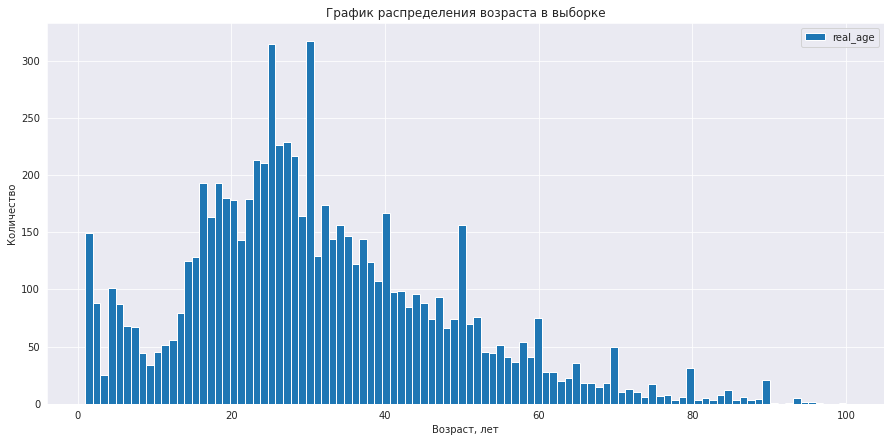

In [6]:
sns.set_style('dark')
labels.plot(kind='hist',figsize=(15,7),bins=100, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

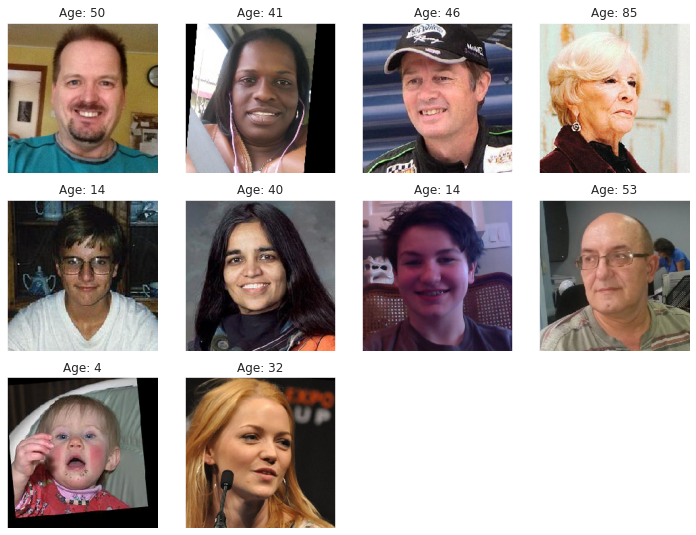

In [7]:
# Выведем 10 фото
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    Результаты EDA:
    
    Общее количество фотографий в датасете составляет 7591;
    
    Большинство людей на фотографиях находятся в возрастной категории от 21 до 40 лет;
    
    В датасете присутствуют черно-белые фотографии различных размеров, а также фотографии, на которых есть преграды перед лицом людей, такие как жвачка или микрофон;
    
    В целом, большинство фотографий ориентированы правильно, однако некоторые из них сняты под значительным углом.

## Обучение модели

```python
    def load_train(path):
        labels = pd.read_csv(path + 'labels.csv')
        datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
        train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

        return train_gen_flow

    def load_test(path):
        labels = pd.read_csv(path + 'labels.csv')
        datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
        test_gen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='validation',
            seed=12345)

        return test_gen_flow


    def create_model(input_shape):

        backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))

        optimizer = Adam(lr=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


        return model


    def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

        if steps_per_epoch is None:
            steps_per_epoch = len(train_data)
        if validation_steps is None:
            validation_steps = len(test_data)

        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, 
                  epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2)

        return model
 ```

    Train for 356 steps, validate for 119 steps
    Epoch 1/10
    2023-10-31 11:58:42.647777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
    2023-10-31 11:58:43.754728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
    356/356 - 70s - loss: 201.0965 - mae: 10.1226 - val_loss: 779.5746 - val_mae: 22.9072
    Epoch 2/10
    356/356 - 39s - loss: 81.3168 - mae: 6.8871 - val_loss: 248.1188 - val_mae: 12.0111
    Epoch 3/10
    356/356 - 39s - loss: 60.0992 - mae: 5.8865 - val_loss: 88.4092 - val_mae: 6.9865
    Epoch 4/10
    356/356 - 39s - loss: 41.1397 - mae: 4.8879 - val_loss: 73.0097 - val_mae: 6.3165
    Epoch 5/10
    356/356 - 41s - loss: 32.2220 - mae: 4.3410 - val_loss: 70.6045 - val_mae: 6.4051
    Epoch 6/10
    356/356 - 41s - loss: 27.2988 - mae: 3.9684 - val_loss: 67.2639 - val_mae: 6.1935
    Epoch 7/10
    356/356 - 41s - loss: 21.3084 - mae: 3.5415 - val_loss: 75.8054 - val_mae: 6.4568
    Epoch 8/10
    356/356 - 41s - loss: 16.7468 - mae: 3.1261 - val_loss: 68.3626 - val_mae: 6.3300
    Epoch 9/10
    356/356 - 40s - loss: 14.0233 - mae: 2.8712 - val_loss: 70.7812 - val_mae: 6.1800
    Epoch 10/10
    356/356 - 39s - loss: 12.4342 - mae: 2.7005 - val_loss: 66.4188 - val_mae: 6.0586
    WARNING:tensorflow:sample_weight modes were coerced from
      ...
    to  
      ['...']
    119/119 - 9s - loss: 66.4188 - mae: 6.0586
    Test MAE: 6.0586

## Анализ обученной модели

Для решения задачи была применена сверточная нейронная сеть на основе архитектуры ResNet50.

За 10 эпох обучения удалось значительно снизить среднюю абсолютную ошибку (MAE) на тренировочной выборке с 10.4 до 2.7, и с 22.9 до 6.06 на тестовой, вероятно, есть потенциал для еще большего улучшения.

Учитывая относительно небольшой объем обучающей выборки, время, затраченное на обучение, оказалось приемлемым.

Анализ обученной модели подчеркивает преимущества использования графического процессора (GPU) и нейронных сетей, позволяющих обрабатывать большие объемы данных с высокой точностью.

Погрешность в 6 лет, за исключением случаев, связанных с продажей алкоголя, несмотря на свою значительность, остается приемлемой для задачи определения возраста.

Полученная модель вполне способна решить поставленную бизнесом задачу, однако всегда есть потенциал для дальнейшего совершенствования.

Архитектура ResNet50 с 50 слоями, использующая skip-connections, свертки малого размера и bottleneck-блоки, оказалась эффективной для данной задачи, что соответствует ее репутации как одной из наиболее успешных архитектур в различных задачах.